In [1]:
# !git clone https://github.com/yongmin21/2022_BigContest.git

In [2]:
# %cd "/content/2022_BigContest"
# !pwd

In [3]:
# !git lfs install
# !git lfs pull origin

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path_gothic = '/etc/fonts/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=path_gothic, size=15)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("deep")

#dir = "/content/2022_BigContest/data/"
dir = "../data/"

In [106]:
train = pd.read_parquet(dir + "train.parquet")
user_spec = pd.read_parquet(dir + "user_spec.parquet")
meta = pd.read_pickle(dir + 'meta.pkl')

data = train.merge(user_spec, how='inner', on='application_id')

In [107]:
data.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,month,user_id,birth_year,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
0,2157865,2022-05-09 08:44:59,54,235,20000000.0,16.5,1.0,5,346970,1970.0,...,EARNEDINCOME,201312.0,정규직,자가,10000000.0,생활비,0.0,NaN,12.0,162000000.0
1,576643,2022-05-09 10:54:53,54,235,11000000.0,16.5,0.0,5,545882,1977.0,...,EARNEDINCOME,201908.0,정규직,전월세,20000000.0,생활비,0.0,NaN,7.0,106000000.0
2,576643,2022-05-09 10:54:53,11,118,3000000.0,20.0,0.0,5,545882,1977.0,...,EARNEDINCOME,201908.0,정규직,전월세,20000000.0,생활비,0.0,NaN,7.0,106000000.0
3,2136706,2022-05-09 10:41:06,42,216,10000000.0,13.5,0.0,5,558819,1983.0,...,EARNEDINCOME,201203.0,정규직,전월세,80000000.0,대환대출,0.0,NaN,2.0,58000000.0
4,2136706,2022-05-09 10:41:07,25,169,22000000.0,15.9,0.0,5,558819,1983.0,...,EARNEDINCOME,201203.0,정규직,전월세,80000000.0,대환대출,0.0,NaN,2.0,58000000.0


**<가설>**
1. 대출 승인은 대출 상환 능력이 높은 사람에게 쉽게 해줄 것이다.  
(신용점수가 가장 영향이 높을 것이고, 정규직, 연봉, 주택소유형태 등에 영향을 많이 받을 것이다.)  
2. 1번과 마찬가지로 개인회생경험이나 기존 대출 금액이 있는 사람은 대출이 힘들 것이다.

In [118]:
def get_nan_table(df, index):
    nan_df = (pd.DataFrame(
        {'total_nan': df.isnull().sum(),
         'ratio': df.isnull().sum() / df.shape[0]},
         index=index
    ))
    return nan_df

get_nan_table(data, meta.index)

,total_nan,ratio
varname,,
loanapply_insert_time,0,0.000000
bank_id,0,0.000000
product_id,0,0.000000
loan_limit,5625,0.000548
loan_rate,5625,0.000548
is_applied,0,0.000000
application_id,0,0.000000
user_id,0,0.000000
birth_year,91626,0.008922


### NaN 처리

In [113]:
# 개인회생여부가 0, nan 이고 개인회생납입완료여부가 nan, nan 이라면 nan값을 특수하게 정의 해주는 것이 필요

# -1로 대치하고 one-hot 인코딩 사용
# 기대출수가 0이라면 기대출금액도 0, 그 외의 nan 값은 knn imputer 사용
data.fillna({'personal_rehabilitation_yn': -1,
             'personal_rehabilitation_complete_yn' : -1,
             'existing_loan_cnt': 0
             }, inplace=True)

data.loc[data['existing_loan_cnt']==0, 'existing_loan_amt'] = (data
                                                               .loc[data['existing_loan_cnt']==0, 'existing_loan_amt']
                                                               .fillna(0))

In [119]:
get_nan_table(data, meta.index)

,total_nan,ratio
varname,,
loanapply_insert_time,0,0.000000
bank_id,0,0.000000
product_id,0,0.000000
loan_limit,5625,0.000548
loan_rate,5625,0.000548
is_applied,0,0.000000
application_id,0,0.000000
user_id,0,0.000000
birth_year,91626,0.008922


In [121]:
test_data = data.dropna(subset=['gender'])

In [122]:
get_nan_table(test_data, meta.index)

,total_nan,ratio
varname,,
loanapply_insert_time,0,0.000000
bank_id,0,0.000000
product_id,0,0.000000
loan_limit,5584,0.000549
loan_rate,5584,0.000549
is_applied,0,0.000000
application_id,0,0.000000
user_id,0,0.000000
birth_year,0,0.000000


* knn imputer를 사용한 결측치 처리
* iterative imputer를 사용한 결측치 처리
* 결측치를 모두 제거해 처리
* gender는 이진분류로 예측

# Categorical Variables
### 0. target 분포 확인

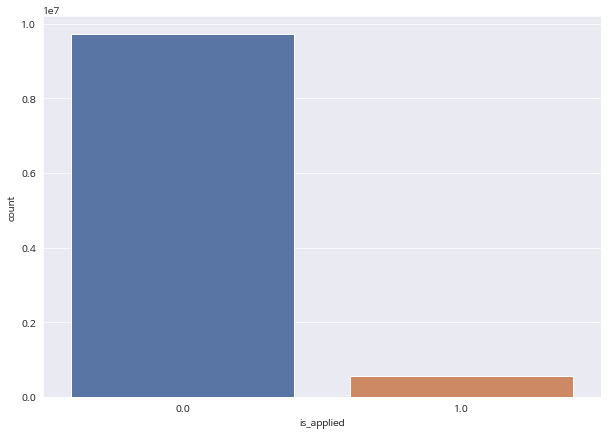

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot(x='is_applied', data=data)

* 아주 심하게 unbalanced된 데이터이다.
* UnderSampling 또는 OverSampling 기법을 통해 적절히 분포를 조정해줘야 할 것이다.
* 모델링 단계에서 stratified k-fold, 교차검증을 통해 충분히 오버피팅을 방지해줄 필요가 있다.
* 검증 metric으로 F1-score, ROC-AUC curve 등을 활용하는 것이 좋다.

In [ ]:
data['is_applied'].value_counts() / len(data['is_applied'])

0.0    0.94544
1.0    0.05456
Name: is_applied, dtype: float64

### correlation 확인
1. Cramers V
    * nominal variables에서 사용하는 correlation 계산 방법
    * 비교 대상 변수 범주가 3개 이상인 경우에 사용  
    * 결과 범위는 0 ~ 1 사이로 높을수록 상관관계가 높다고 해석됨.

    https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix/notebook

In [131]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
cat_data = data[v]
cat_data.head()

,loanapply_insert_time,bank_id,product_id,income_type,employment_type,houseown_type,purpose
0,2022-05-09 08:44:59,54,235,EARNEDINCOME,정규직,자가,생활비
1,2022-05-09 10:54:53,54,235,EARNEDINCOME,정규직,전월세,생활비
2,2022-05-09 10:54:53,11,118,EARNEDINCOME,정규직,전월세,생활비
3,2022-05-09 10:41:06,42,216,EARNEDINCOME,정규직,전월세,대환대출
4,2022-05-09 10:41:07,25,169,EARNEDINCOME,정규직,전월세,대환대출


In [130]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

for f in cat_data.columns:
    data_encoded[f] = label.fit_transform(cat_data[f])

data_encoded.head()

,loanapply_insert_time,bank_id,product_id,income_type,employment_type,houseown_type,purpose
0,1768163,51,150,0,3,2,11
1,1773382,51,150,0,3,3,11
2,1773382,10,72,0,3,3,11
3,1772751,41,135,0,3,3,9
4,1772752,24,106,0,3,3,9


In [ ]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

### 1. 어떤 은행에서 가장 많이 대출을 승인해줬을까?

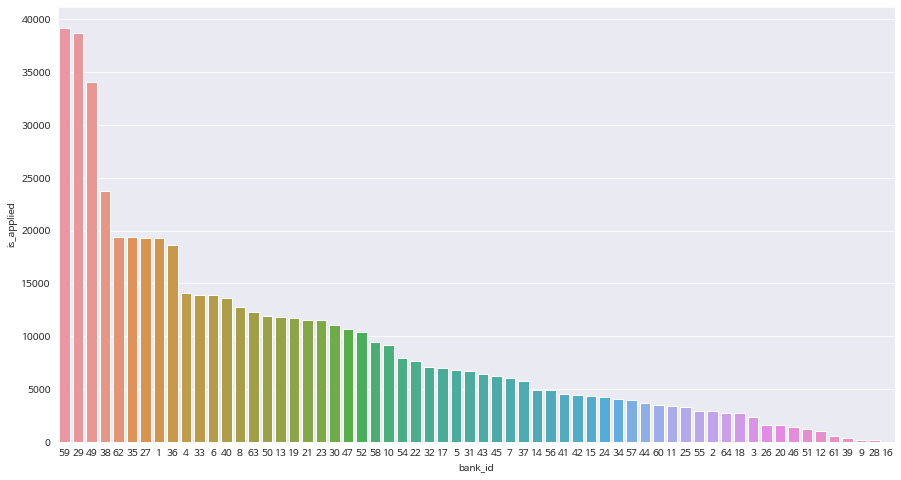

In [ ]:
v = (data
     .loc[data['is_applied'] == 1]
     .groupby('bank_id', as_index=False)
     .count()[['bank_id', 'is_applied']]
     .sort_values('is_applied', ascending=False))

plt.figure(figsize=(15,8))
sns.barplot(data=v, x='bank_id', y='is_applied', order=v['bank_id'])

* 59번, 29번 은행에서 가장 많은 대출 승인을 해주었고, 그 뒤로 49, 38, 62, ... 순으로 많았다.
* 대출 신청 건 수가 매우 적은 은행도 있었다. (16번 - 4건)
* 각 은행별 대출 승인 비율로 확인해보자

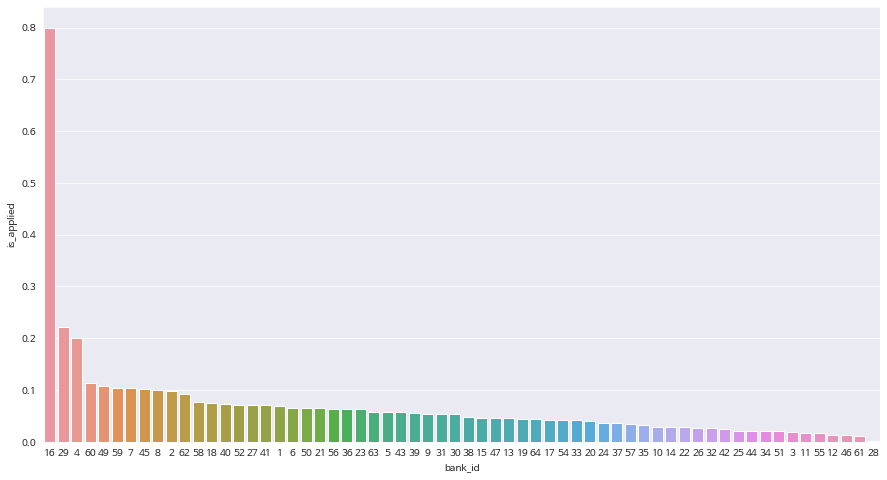

In [ ]:
applied = (data.loc[data['is_applied'] == 1, ['bank_id', 'is_applied']]
           .groupby('bank_id', as_index=False)
           .count()[['bank_id', 'is_applied']]
           )
ratio = (data[['bank_id', 'is_applied']]
         .groupby('bank_id', as_index=False)
         .count()[['bank_id', 'is_applied']]
         )

ratio['is_applied'] = applied['is_applied'] / ratio['is_applied']
v = ratio.sort_values('is_applied', ascending=False)
del applied
del ratio

plt.figure(figsize=(15, 8))
sns.barplot(data=v, x='bank_id', y='is_applied', order=v['bank_id'])

* 16번은 대출 승인 건수가 가장 적었지만 대부분 승인해주었던 것을 알 수 있다.
* 대부분의 대출 승인 비율은 0.1을 넘지 않는다. (imbalanced를 다시 한번 확인하였음)

그렇다면 대출 신청 건수가 많은 은행들은 적은 은행들과 무슨 차이가 있을까? (매력적인 대출 상품들이 있을까?)  
또 대출 승인 비율이 높은 은행은 그 이유가 무엇일까? (고객의 특수성인가 또는 제1,2 금융권이 아닌 은행들일까?)

In [ ]:
v = (data[['bank_id', 'product_id']]
     .drop_duplicates() # 은행별 서로 다른 대출 상품 수를 보기 위해
     .groupby('bank_id')
     .count()
     .sort_values('product_id', ascending=False))
v[:20]

,product_id
bank_id,
35,14
55,11
34,8
30,7
36,6
25,5
24,5
38,5
47,4


### 2. 소득 유형에 따른 대출 승인 건 수의 차이가 있을까?

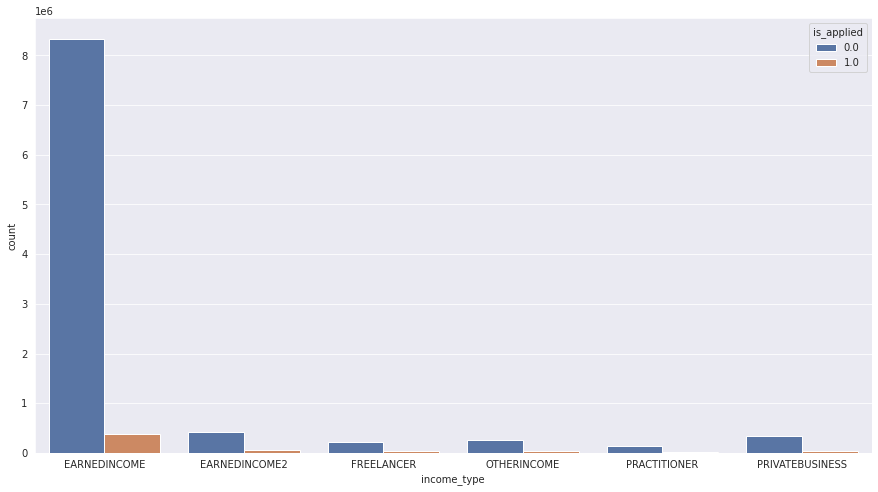

In [ ]:
v = data[['income_type', 'is_applied']]

plt.figure(figsize=(15, 8))
sns.countplot(data=v, x='income_type', hue='is_applied')

* 그래프에서 EARNEDINCOME의 0 비율이 너무 커서 잘 안보인다.
* 로그스케일로 변환해보자

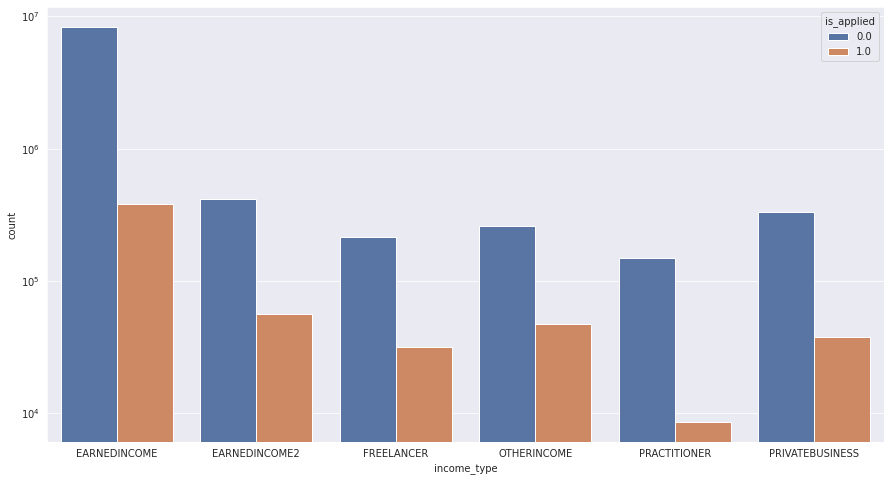

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=v, x='income_type', hue='is_applied', ax=ax)
ax.set_yscale('log')

<AxesSubplot:xlabel='income_type', ylabel='is_applied'>

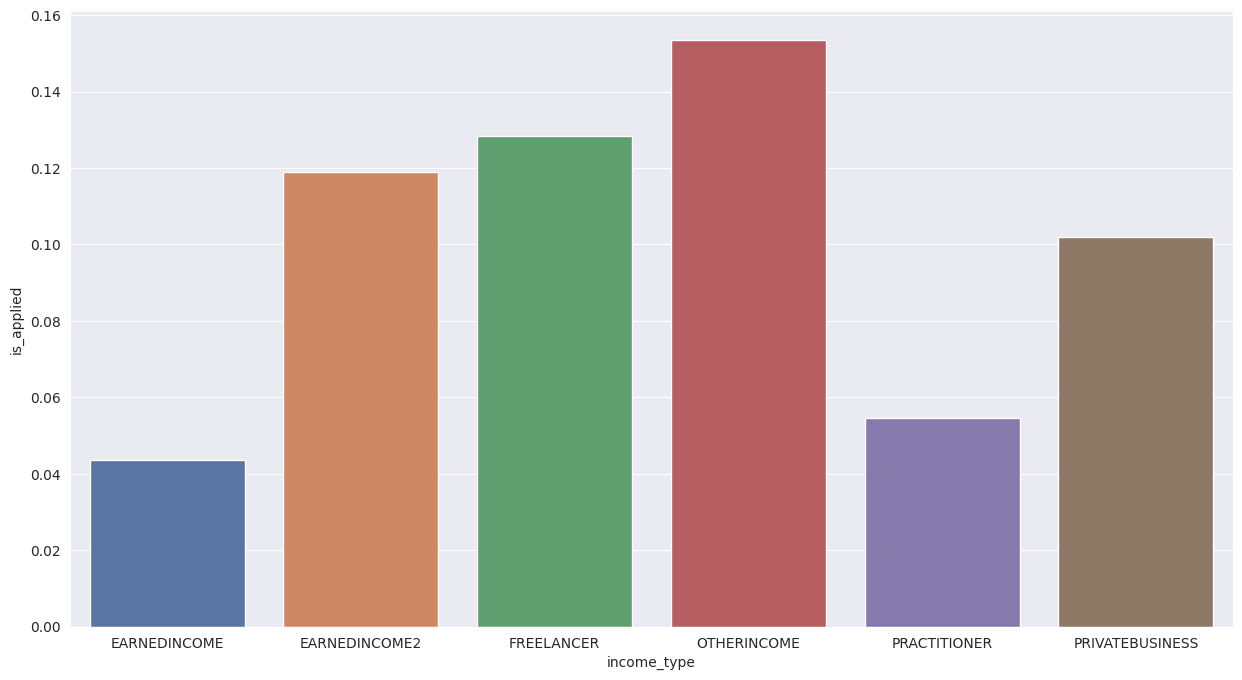

In [15]:
applied = (data.loc[data['is_applied'] == 1, ['income_type', 'is_applied']]
           .groupby('income_type', as_index=False)
           .count()[['income_type', 'is_applied']]
           )
ratio = (data[['income_type', 'is_applied']]
         .groupby('income_type', as_index=False)
         .count()[['income_type', 'is_applied']]
         )

ratio['is_applied'] = applied['is_applied'] / ratio['is_applied']
v = ratio.sort_values('is_applied', ascending=False)
del applied
del ratio

fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(data=v, x='income_type', y='is_applied', ax=ax)


* EARNEDINCOME이 가장 많은 대출 신청을 하였고, 가장 많은 승인을 받았다.
* PRACTITIONER가 가장 적은 대출 신청을 하였고, 가장 적은 승인을 받았다.
* 승인 건 수는 EARNEDINCOME, EARNEDINCOME2, OTHERINCOME, PRIVATEBUSINESS, FREELANCER, PRACTITIONER 순으로 줄어든다.
* **대출 승인이 되려면 역시 안정적인 수입원이 있어야 하는 것을 알 수 있다.**
* 비율로 보면 오히려 잘 승인해주는 건 OTHERINCOME이다.

### 3. employment_type에 따른 대출 승인 건 수의 차이가 있을까?

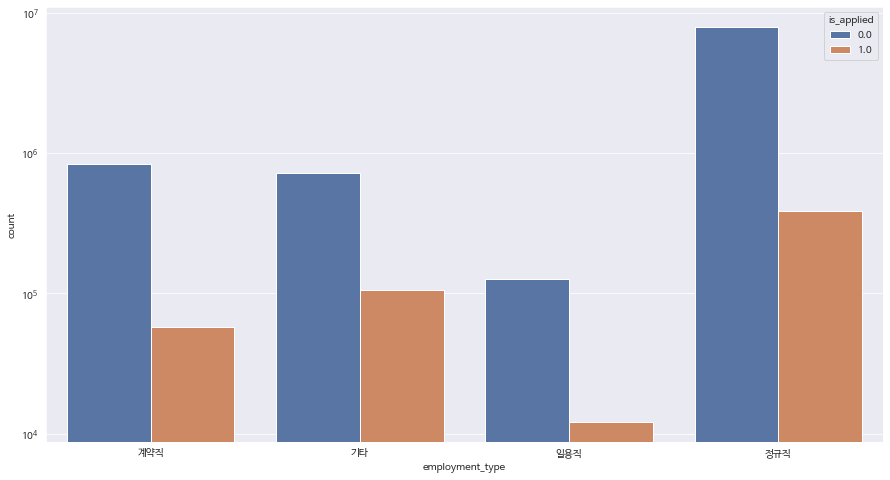

In [ ]:
v = data[['employment_type', 'is_applied']]

fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=v, x='employment_type', hue='is_applied', ax=ax)
ax.set_yscale('log')

In [10]:
applied = (data.loc[data['is_applied'] == 1, ['employment_type', 'is_applied']]
           .groupby('employment_type', as_index=False)
           .count()[['employment_type', 'is_applied']]
           )
ratio = (data[['employment_type', 'is_applied']]
         .groupby('employment_type', as_index=False)
         .count()[['employment_type', 'is_applied']]
         )

ratio['is_applied'] = applied['is_applied'] / ratio['is_applied']
v = ratio.sort_values('is_applied', ascending=False)
del applied
del ratio

# fig, ax = plt.subplots(figsize=(15,8))
# sns.barplot(data=v, x='employment_type', y='is_applied', ax=ax)
v

,employment_type,is_applied
1,기타,0.127123
2,일용직,0.087342
0,계약직,0.064042
3,정규직,0.045833


* 역시 정규직이 가장 많은 승인을 받았고, 기타, 계약직, 일용직 순으로 줄어든다.  
* 대출의 승인을 잘 받으려면 **대출 상환 능력(가능성)**을 우선시하는 것이 보인다.

### 집 소유 유형별 대출 승인 수 비교

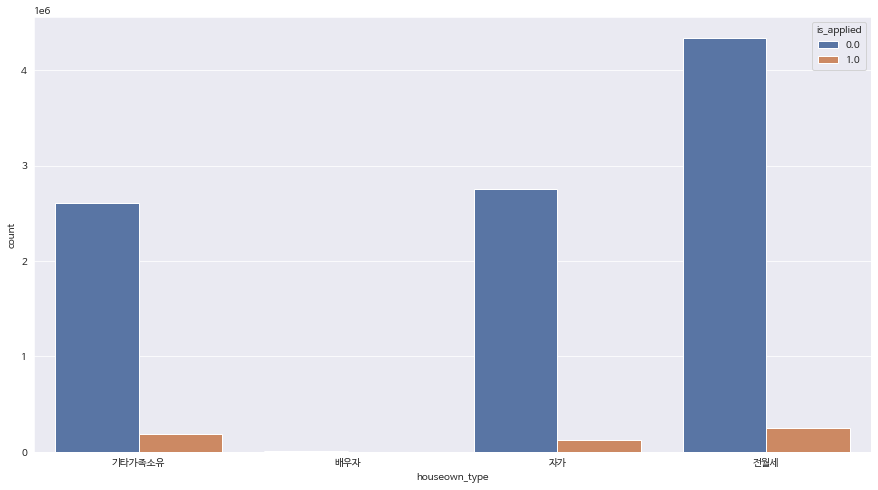

In [ ]:
v = data[['houseown_type', 'is_applied']]

plt.figure(figsize=(15,8))
sns.countplot(data=v, x='houseown_type', hue='is_applied')
plt.show()

In [ ]:
pd.crosstab(data['is_applied'], data['houseown_type'])

houseown_type,기타가족소유,배우자,자가,전월세
is_applied,,,,
0.0,2602562,11796,2755208,4340109
1.0,184649,469,121072,254146


* 전체 신청자들 중에서는 전월세, 자가, 기타가족소유, 배우자 순으로 수가 많았다.
* 집을 소유하고 있는 사람들의 수가 전월세의 수보다 더 많다.
* 전월세로 사는 사람들이 대출을 더 많이 받았다.

### 4. 어떤 대출 목적이 대출 승인을 많이 받았을까?

/home/yongmin/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  func(*args, **kwargs)
/home/yongmin/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  func(*args, **kwargs)
/home/yongmin/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*args, **kwargs)
/home/yongmin/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from current font.
  func(*args, **kwargs)
/home/yongmin/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  func(*args, **kwargs)
/home/yongmin/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49324 (\N{

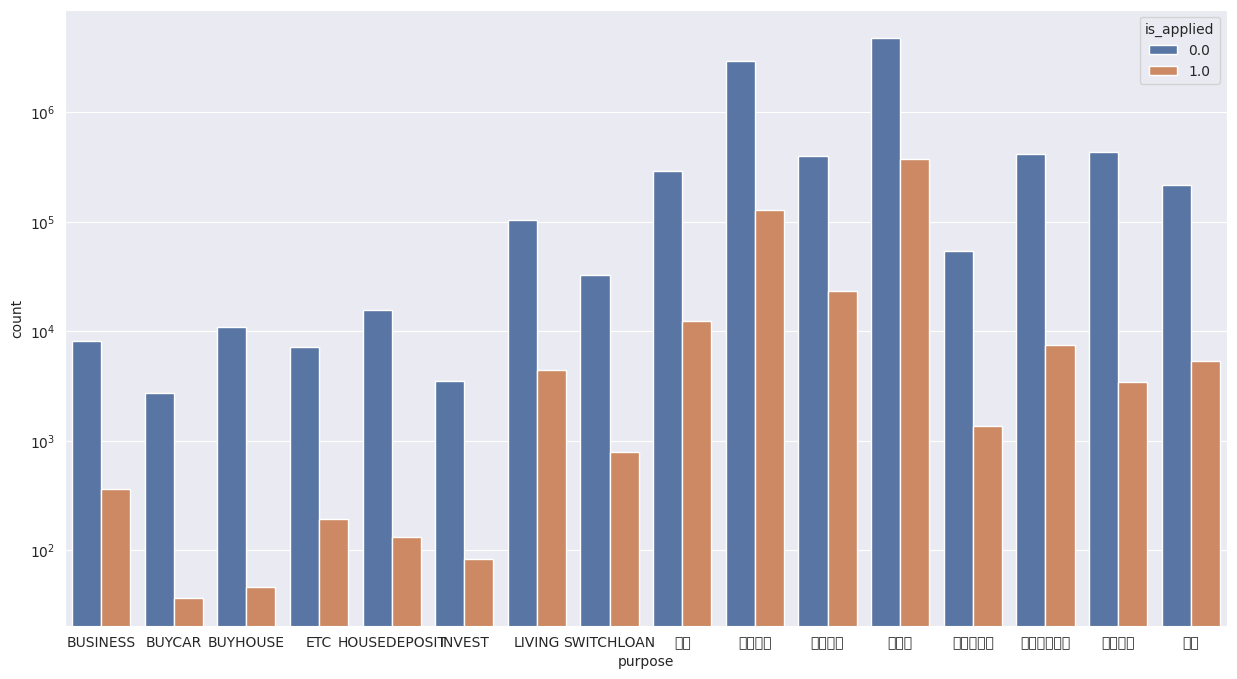

In [12]:
v = data[['purpose', 'is_applied']]

fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(data=v, x='purpose', hue='is_applied', ax=ax)
ax.set_yscale('log')

* 생활비 승인이 가장 많았고, 대환대출, 사업자금, 기타, 전월세보증금 순으로 많다.

### 6. 개인 회생 여부별 대출 승인 수 차이가 있을까?

In [ ]:
print(len(data.loc[data['personal_rehabilitation_yn'] == 1.]))
print(len(data['personal_rehabilitation_yn']))
print(len(data['personal_rehabilitation_complete_yn']))

23051
10270011
10270011


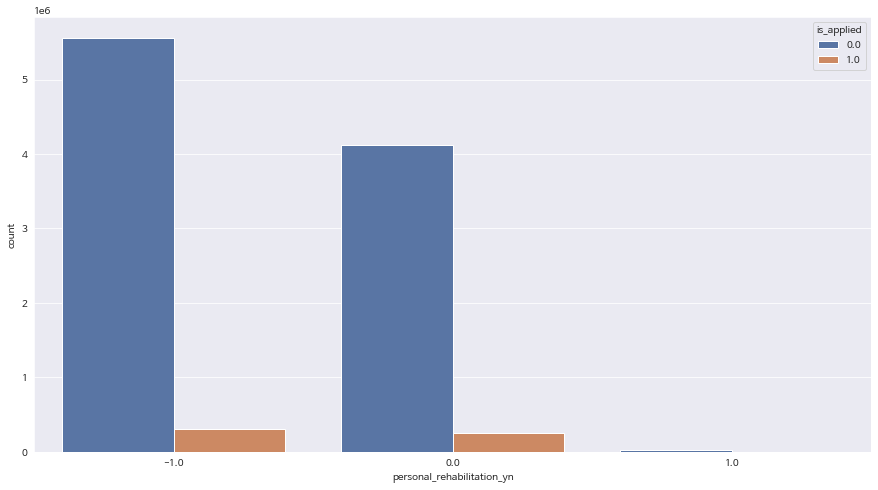

In [ ]:
v = data[['personal_rehabilitation_yn', 'is_applied']]
v = v.fillna(-1.)

plt.figure(figsize=(15, 8))
sns.countplot(data=v, x='personal_rehabilitation_yn', hue='is_applied')

* 개인 회생 여부의 nan값을 -1로 대치하였다.
* 개인 회생 신청을 했던 사람들은 대출조차 어려운 경우가 많다. (실제 대출 신청 수가 엄청 적은 것을 알 수 있음)

### 10. 성별에 따른 대출 승인 건 수의 차이가 있을까?

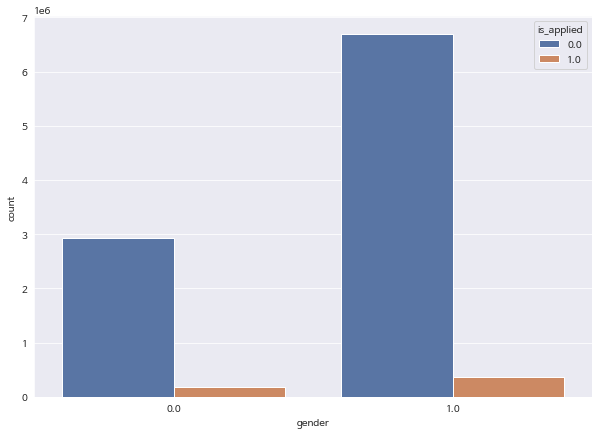

In [ ]:
v = data[['gender', 'is_applied']]

plt.figure(figsize=(10,7))
sns.countplot(data=v, x='gender', hue='is_applied')

* 성별 1이 성별 0보다 대출 신청 건 수는 두 배 이상이며, 대출 승인 건 수도 약 두 배정도로 더 많다.  
  

* 성별에 따른 스펙 차이가 존재해서 승인 건 수도 차이가 나는 것은 아닐까?
* 또는 성별 1이 주로 경제활동을 담당하고 있기 때문에 성별 1이 더 많이 대출 신청을 하는 것이 아닐까?

<AxesSubplot:xlabel='existing_loan_cnt', ylabel='percent'>

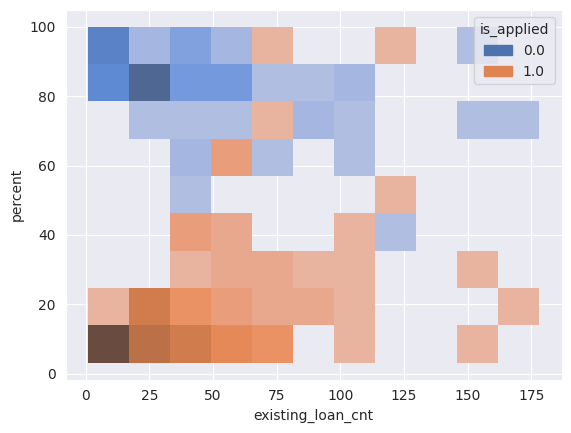

In [94]:
v = (data[['existing_loan_cnt', 'is_applied']]
.groupby('existing_loan_cnt')['is_applied']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index())

sns.histplot(data=v, x='existing_loan_cnt', y='percent', hue='is_applied')


In [96]:
v.loc[v['is_applied']==1].corr()

,existing_loan_cnt,is_applied,percent
existing_loan_cnt,1.00000,NaN,0.37424
is_applied,NaN,NaN,NaN
percent,0.37424,NaN,1.00000


In [97]:
v.loc[v['is_applied']==0].corr()

,existing_loan_cnt,is_applied,percent
existing_loan_cnt,1.000000,NaN,-0.272819
is_applied,NaN,NaN,NaN
percent,-0.272819,NaN,1.000000


**정리하면**, target 데이터는 매우 심한 imbalanced 데이터이며, 샘플링을 통해 처리해야 할 것이다.  
또 대출 승인 여부는 해당 고객이 상환 가능성이 높은 경우에 주로 승인을 해주는 것을 알 수 있다.  


# Interval (Numeric) Variables

'application_id', 'loanapply_insert_time', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'is_applied', 'month', 'user_id',
       'birth_year', 'gender', 'insert_time', 'credit_score', 'yearly_income',
       'income_type', 'company_enter_month', 'employment_type',
       'houseown_type', 'desired_amount', 'purpose',
       'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn',
       'existing_loan_cnt', 'existing_loan_amt'

### 상관관계 파악

In [ ]:
#v = meta[(meta.level == 'interval') & (meta.keep)].index

### 데이터 분포 파악